In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score


df_not_outliers = pd.read_csv('../intermedio_sin_outliers.csv')

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])
y_sin_outliers = df_not_outliers['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y_sin_outliers, test_size=0.2, random_state=42
)


In [18]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 01m 11s]
val_mae: 4192.1083984375

Best val_mae So Far: 4044.100830078125
Total elapsed time: 00h 10m 29s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model2(best_hp3)
history2 = model3.fit(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_data=(X_test_sin_outliers, y_test_sin_outliers),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 19644.4336 - mae: 19638.0332 - r2: -1.1964 - rmse: 27110.5938 - val_loss: 5290.1626 - val_mae: 5273.7603 - val_r2: 0.6013 - val_rmse: 11944.8369
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6198.8394 - mae: 6182.2231 - r2: 0.5823 - rmse: 12617.2881 - val_loss: 5016.0703 - val_mae: 4998.5801 - val_r2: 0.6780 - val_rmse: 10734.4854
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5846.5186 - mae: 5828.5137 - r2: 0.6077 - rmse: 11746.1514 - val_loss: 4548.7300 - val_mae: 4529.6284 - val_r2: 0.7504 - val_rmse: 9451.8945
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5847.2354 - mae: 5827.7305 - r2: 0.6144 - rmse: 12124.4688 - val_loss: 4529.5107 - val_mae: 4508.9893 - val_r2: 0.7497 - val_rmse: 9464.7891
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5607.1885 - mae: 5586.2637 - r2: 0.6658 - rmse: 11379.6035 - val_loss: 4447.9722 - val_mae: 4426.2622 - val_r2: 0.7242 - val_rmse: 

In [23]:
print (best_hp3.values)
print (best_hp3)

{'units_1': 128, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.30000000000000004, 'units_3': 48, 'lr': 0.01}


In [20]:
y_pred = model3.predict(X_test_sin_outliers).flatten()

mae = mean_absolute_error(y_test_sin_outliers, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred))
r2 = r2_score(y_test_sin_outliers, y_pred)
mape = np.mean(np.abs((y_test_sin_outliers - y_pred) / y_test_sin_outliers)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")



109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- MÉTRICAS ---
MAE: $3,884
RMSE: $7,769
R2: 0.831
MAPE: 17.25%


In [21]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [25]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 35s]
val_mae: 5751.251953125

Best val_mae So Far: 3081.704833984375
Total elapsed time: 00h 12m 52s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
print(best_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 192)            │        10,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,377 (99.13 KB)

 Trainable params: 24,865 (97.13 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [ ]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

--- MÉTRICAS ---
MAE: $3,033
RMSE: $4,660
R2: 0.807
MAPE: 12.67%


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)
print(best_hp.values)
print(best_hp)

Epoch 1/50


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 19728.5820 - mae: 19725.3906 - r2: -3.7681 - rmse: 22825.4805 - val_loss: 4989.5312 - val_mae: 4977.5977 - val_r2: 0.5992 - val_rmse: 6724.3794
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 5759.5498 - mae: 5747.2407 - r2: 0.4516 - rmse: 7775.3579 - val_loss: 3795.9255 - val_mae: 3782.4951 - val_r2: 0.7383 - val_rmse: 5433.4004
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 5064.2666 - mae: 5050.4849 - r2: 0.5640 - rmse: 6974.6738 - val_loss: 3696.9412 - val_mae: 3681.9370 - val_r2: 0.7277 - val_rmse: 5541.9995
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 4586.1626 - mae: 4570.7935 - r2: 0.6312 - rmse: 6426.9658 - val_loss: 3461.5059 - val_mae: 3445.1335 - val_r2: 0.7693 - val_rmse: 5101.0879
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 4319.5928 - mae: 4302.8184 - r2: 0.6648 - rmse: 6078.3867 - val_loss: 3661.3333 - val_mae: 3643.6643 - val_r2: 0.7632 - val_rmse: 5168.62

In [ ]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [ ]:
# Modelo
def build_model3(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner3 = kt.RandomSearch(
    build_model3,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner3.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner3.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 14s]
val_mae: 17855.65625

Best val_mae So Far: 3588.046875
Total elapsed time: 00h 02m 37s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model3(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 27966.9316 - mae: 27966.5195 - r2: -2.2712 - rmse: 33646.2930 - val_loss: 26116.7656 - val_mae: 26114.8027 - val_r2: -1.7715 - val_rmse: 33397.6992
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 24266.2734 - mae: 24263.1680 - r2: -1.7203 - rmse: 31997.2910 - val_loss: 15622.3164 - val_mae: 15615.0908 - val_r2: -0.6904 - val_rmse: 26082.7930
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 12605.3125 - mae: 12596.4209 - r2: -0.3325 - rmse: 21807.6875 - val_loss: 7023.9819 - val_mae: 7011.3594 - val_r2: 0.4803 - val_rmse: 14461.8740
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 7253.4888 - mae: 7240.3403 - r2: 0.4983 - rmse: 13673.5957 - val_loss: 4998.4214 - val_mae: 4984.3535 - val_r2: 0.6702 - val_rmse: 11520.4043
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 6661.9893 - mae: 6647.8193 - r2: 0.5714 - rmse: 12019.9512 - val_loss: 4437.3838 - val_mae: 4422.7417 - val

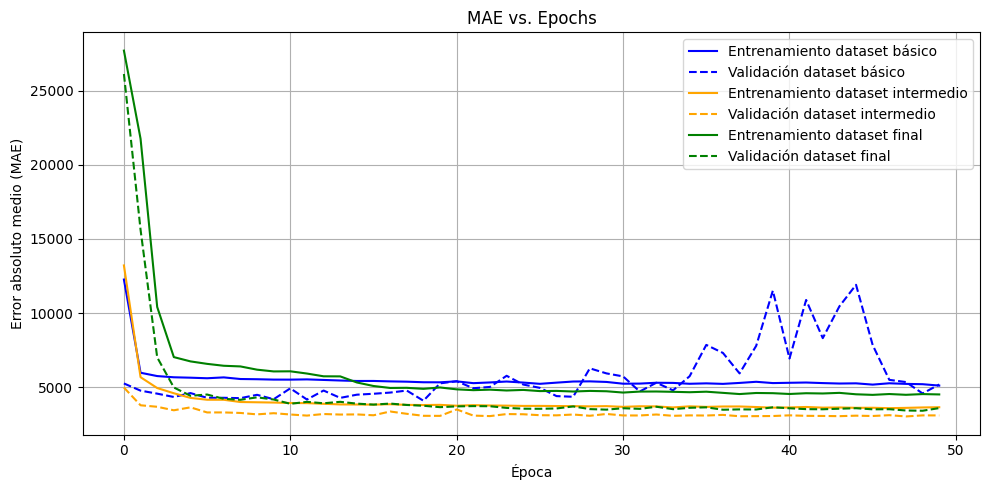

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history2.history['val_mae'], label='Validación dataset básico',color='blue', linestyle='--')
plt.plot(history1.history['mae'], label='Entrenamiento dataset intermedio',color='orange')
plt.plot(history1.history['val_mae'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


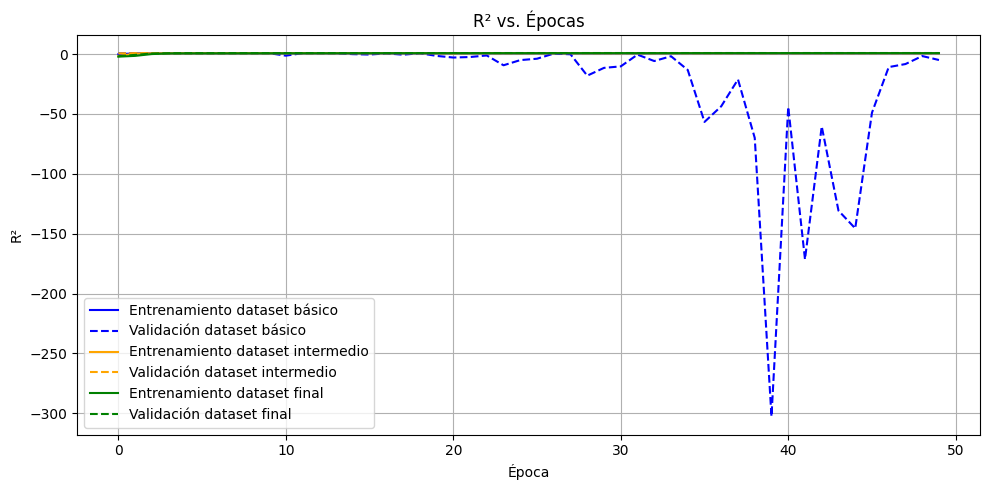

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['r2'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history2.history['val_r2'], label='Validación dataset básico', linestyle='--', color='blue')
plt.plot(history1.history['r2'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history1.history['val_r2'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['r2'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_r2'], label='Validación dataset final', linestyle='--', color='green')
plt.title('R² vs. Épocas')
plt.xlabel('Época')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 

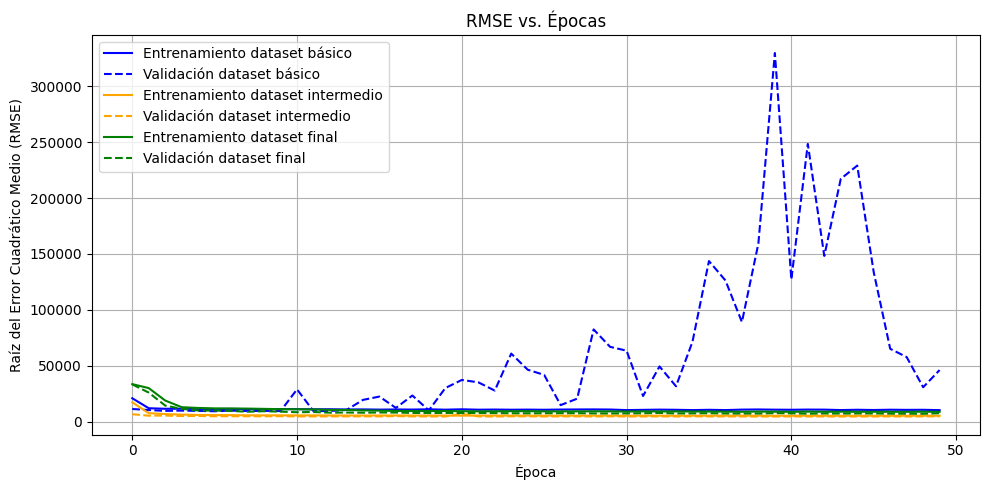

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['rmse'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history2.history['val_rmse'], label='Validación dataset básico', linestyle='--', color='blue')
plt.plot(history1.history['rmse'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history1.history['val_rmse'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['rmse'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_rmse'], label='Validación dataset final', linestyle='--', color='green')
plt.title('RMSE vs. Épocas')
plt.xlabel('Época')
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
